In [1]:
import openslide
import numpy as np
from pylab import *

# 读取包含有肿瘤区域的大图（全切片病理图像）
origin_images_path = "/atlas/home/zwpeng/paper_rebuild/camelyon/train/tumor/origin_images/Tumor_005.tif"
origin_slide = openslide.open_slide(origin_images_path)

# 读取该肿瘤区域的标注图
annotation_images_path = "/atlas/home/zwpeng/paper_rebuild/camelyon/train/tumor/annotation_images/Tumor_005_Mask.tif"
mask_slide = openslide.open_slide(annotation_images_path)

In [2]:
from pylab import *
import numpy as np

# 感兴趣区域锁定函数
def locate_ROI(origin_slide,level=6):

    origin_widths,origin_heights = origin_slide.dimensions

    object_widths,object_heights = origin_slide.level_dimensions[level]

    rgb_list_y = list()
    rgb_list_x = list()
    rgb_var_x = []
    rgb_var_y = []
    rgb_var_xi = []
    rgb_var_yi = []

    # 寻找有效区域的y值、高度
    for k in range(100):
        slide = origin_slide.read_region((0, k*origin_heights//100), level, (object_widths, object_heights//50)) 
        slide_arr = array(slide.convert("RGB"))
        arrR = np.mean(slide_arr[:,:,:1])
        arrG = np.mean(slide_arr[:,:,1:2])
        arrB = np.mean(slide_arr[:,:,2:3])
        rgb_list_y.append((arrR,arrG,arrB))
    for i,rgbVar in enumerate(rgb_list_y):
        rgb_var_y.append(np.var(rgbVar))
        if np.var(rgbVar)>=1:
            rgb_var_yi.append(i)

#     print(rgb_var_yi)
    effective_y = min(rgb_var_yi)*origin_heights//100        #有效区域的左上顶点y坐标找到了
    effective_heights = (max(rgb_var_yi)-min(rgb_var_yi))*origin_heights//100 + origin_heights//50  #有效区域的高度也出来了
#     print("有效区域的ｙ值是：%d" %effective_y, "有效区域的高度是：%d" %effective_heights)

    # 寻找有效区域的x值、宽度
    for j in range(100):
        slide = origin_slide.read_region((j*origin_widths//100, effective_y), level, 
                                          (object_widths//50, effective_heights//62))     # 循环顺序读取50宽的区域
    #     slide = origin_slide.read_region((j*origin_widths//100, 0), level, 
    #                                       (object_widths//50, object_heights))     # 循环顺序读取50宽的区域

        slide_arr = array(slide.convert("RGB"))
        arrR = np.mean(slide_arr[:,:,:1])
        arrG = np.mean(slide_arr[:,:,1:2])
        arrB = np.mean(slide_arr[:,:,2:3])
        rgb_list_x.append((arrR,arrG,arrB))
    for i,rgbVar in enumerate(rgb_list_x):
        rgb_var_x.append(np.var(rgbVar))
        if np.var(rgbVar)>=2:
            rgb_var_xi.append(i)

#     print(rgb_var_xi)
    effective_x = min(rgb_var_xi)*origin_widths//100        # 有效区域的左上顶点y坐标找到了
    effective_widths = (max(rgb_var_xi) - min(rgb_var_xi))*origin_widths//100 + origin_widths//50  # 有效区域的宽度也出来了
    return effective_x,effective_y,effective_widths,effective_heights

In [3]:
effective_x,effective_y,effective_widths,effective_heights = locate_ROI(origin_slide)

In [4]:
from pylab import *
import numpy as np

def locate_ROI_mask(mask_slide,mask_level=7):

    # level0　的尺寸
    mask_widths, mask_heights = mask_slide.dimensions
    # level7 的尺寸
    mask_level_widths, mask_level_heights = mask_slide.level_dimensions[mask_level]

    mask_level_slide = mask_slide.read_region((0, 0), mask_level, (mask_level_widths, mask_level_heights))
    mask_level_slide_gray = mask_level_slide.convert("L")
    mask_level_slide_arr = array(mask_level_slide_gray)

    mask_y, mask_x = nonzero(mask_level_slide_arr)  # 因为mask是黑白图，只需直接获得非零像素的坐标
    # mask_x, mask_y
    tumor_leftup_x = (min(mask_x)-1) * int(mask_slide.level_downsamples[mask_level])
    tumor_leftup_y = (min(mask_y)-1) * int(mask_slide.level_downsamples[mask_level])
    tumor_rightdown_x = (max(mask_x)+1) * int(mask_slide.level_downsamples[mask_level])
    tumor_rightdown_y = (max(mask_y)+1) * int(mask_slide.level_downsamples[mask_level])
    
#     print(tumor_leftup_x,tumor_leftup_y,tumor_rightdown_x,tumor_rightdown_y)
    mask_effective_widths = tumor_rightdown_x - tumor_leftup_x
    mask_effective_heights = tumor_rightdown_y - tumor_leftup_y
    
#     mask_tumor_area = ((max(mask_x)-min(mask_x)+2)*int(mask_slide.level_downsamples[mask_level]), 
#                        (max(mask_y)-min(mask_y)+2)*int(mask_slide.level_downsamples[mask_level]))
#     print(mask_tumor_area)        # mask区域的长宽
    return tumor_leftup_x,tumor_leftup_y,mask_effective_widths,mask_effective_heights

In [5]:
tumor_leftup_x,tumor_leftup_y,mask_effective_widths,mask_effective_heights = locate_ROI_mask(mask_slide)

In [6]:
import numpy as np
from PIL.Image import Image
from pylab import *
from keras.preprocessing import image
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt

# 随机生成一个０到１之间的数，判断是否大于0.5,如果大于0.5,就从tumor区（mask）获取随机点（产生随机图片）；
# 如果小于0.5,就从normal区获取随机点，产生的随机图片需要判断是否取到了tumor
# for i in range(30):    # 这个其实就是 batch_size
#     widths, heights = 299, 299
def data_generator(widths=299,heights=299):
    while True:
        random_num = np.random.random(1)
        print("0到１之间的随机数是：%s"%random_num)

        if random_num > 0.5:
            # 定义随机坐标,一定要取到一张含有tumor的图片
            random_x = np.random.randint(tumor_leftup_x, tumor_leftup_x + mask_effective_widths - widths)  
            random_y = np.random.randint(tumor_leftup_y, tumor_leftup_y + mask_effective_heights - heights)
    #             print("取tumor随机点坐标是：%d,%d"%(random_x,random_y))
            random_img_mask = mask_slide.read_region((random_x,random_y),0,(widths,heights))
            random_img_mask_arr = array(random_img_mask.convert("L"))
            random__img_y, random_img_x = nonzero(random_img_mask_arr)
            while len(random_img_x)==0:
                random_x = np.random.randint(tumor_leftup_x, tumor_leftup_x + mask_effective_widths - widths)
                random_y = np.random.randint(tumor_leftup_y, tumor_leftup_y + mask_effective_heights - heights)
    #                 print("取tumor随机点坐标是：%d,%d"%(random_x,random_y))
                random_img_mask = mask_slide.read_region((random_x,random_y),0,(widths,heights))
                random_img_mask_arr = array(random_img_mask.convert("L"))
                random__img_y, random_img_x = nonzero(random_img_mask_arr)

            #*********************上面这个 while 循环结束后，就产生了一个合格的坐标点*********************#
            random_img = origin_slide.read_region((random_x,random_y),0,(widths,heights))

            #***接下来就给他贴标签，并处理成训练所需的数据结构***#
            random_img_arr = array(random_img.convert("RGB"))
            x = np.expand_dims(random_img_arr, axis=0)/255.
            y = to_categorical(0,2)    
        else:
            # 定义随机坐标，一定要取到一张不含有tumor的normal图片
            random_x = np.random.randint(effective_x,effective_x+effective_widths-widths)   # 大图上,nomal有效区的起点和终点
            random_y = np.random.randint(effective_y,effective_y+effective_heights-heights)
    #             print("取normal随机点坐标是：%d,%d"%(random_x,random_y))
            random_img_mask = mask_slide.read_region((random_x,random_y),0,(widths,heights))
            random_img_mask_arr = array(random_img_mask.convert("L"))
            random__img_y, random_img_x = nonzero(random_img_mask_arr)
            random_img = origin_slide.read_region((random_x,random_y),0,(widths,heights))

#             print("随机情况",len(random_img_x),(array(random_img.convert("RGB"))).std())

            while (array(random_img.convert("RGB"))).std()<20.0:
                random_x = np.random.randint(effective_x,effective_x+effective_widths-widths)
                random_y = np.random.randint(effective_y,effective_y+effective_heights-heights)
    #                 print("取normal随机点坐标是：%d,%d" %(random_x,random_y))
                random_img_mask = mask_slide.read_region((random_x,random_y),0,(widths,heights))
                random_img_mask_arr = array(random_img_mask.convert("L"))
                random__img_y, random_img_x = nonzero(random_img_mask_arr)
                random_img = origin_slide.read_region((random_x,random_y),0,(widths,heights))

#             print("颜色检测情况",len(random_img_x),(array(random_img.convert("RGB"))).std())

            while len(random_img_x) != 0:
                random_x = np.random.randint(effective_x,effective_x+effective_widths-widths)
                random_y = np.random.randint(effective_y,effective_y+effective_heights-heights)
    #                 print("取normal随机点坐标是：%d,%d" %(random_x,random_y))
                random_img_mask = mask_slide.read_region((random_x,random_y),0,(widths,heights))
                random_img_mask_arr = array(random_img_mask.convert("L"))
                random__img_y, random_img_x = nonzero(random_img_mask_arr)
                random_img = origin_slide.read_region((random_x,random_y),0,(widths,heights))

#             print("非tumor区检测情况",len(random_img_x), (array(random_img.convert("RGB"))).std())

            #*********************上面这个 while 循环结束后，就产生了一个合格的坐标点*********************#
            random_img = origin_slide.read_region((random_x,random_y),0,(widths,heights))

            #***接下来就给他贴标签，并处理成训练所需的数据结构***#
            random_img_arr = array(random_img.convert("RGB"))
            x = np.expand_dims(random_img_arr, axis=0)/255.
            y = to_categorical(1,2) 
        yield (x,y)

Using TensorFlow backend.


In [9]:
%time example_X, example_y  = next(data_generator())    # yield要用next调用

0到１之间的随机数是：[ 0.07129304]
CPU times: user 124 ms, sys: 78.5 ms, total: 202 ms
Wall time: 258 ms


In [ ]:
example_X

In [13]:
from keras.models import load_model

def predict_from_model(patch, model_path):
    """Predict which pixels are tumor.
    
    input: patch: 256x256x3, rgb image
    input: model: keras model
    output: prediction: 256x256x1, per-pixel tumor probability
    """
    model = load_model(model_path)
    
    prediction = model.predict(patch.reshape(1, 299, 299, 3))
    prediction = prediction[:, :, :, 1].reshape(299, 299)
    return prediction

In [14]:
import matplotlib.gridspec as gridspec
import cv2

def plot_blend(patch, prediction, ax, alpha=0.75):
    """alpha blend patch and prediction.
    https://matplotlib.org/examples/pylab_examples/layer_images.html
    
    input: patch: 256x256x3, rgb image
    input: prediction: 256x256x1, per-pixel tumor probability
    input: ax: maplotlib Axes object
    input: alpha: alpha blend
    """
    
    dx, dy = 0.05, 0.05
    x = np.arange(0, patch.shape[1] - 1, dx)
    y = np.arange(0, patch.shape[0] - 1, dy)
    xmin, xmax, ymin, ymax = np.amin(x), np.amax(x), np.amin(y), np.amax(y)
    extent = xmin, xmax, ymin, ymax

    # fig = plt.figure(frameon=False, figsize=(10, 5))
    Z1 = cv2.cvtColor(patch, code=cv2.COLOR_RGB2GRAY)
    Z2 = prediction

    im1 = ax.imshow(Z1, cmap='gray', extent=extent)
    im2 = ax.imshow(Z2, cmap='jet', alpha=alpha, vmin=0.0, vmax=1.0,
                     extent=extent)
    ax.axis('off');

def plot_patch_with_pred(patch, truth, prediction, title_str='', alpha=0.6):
    """
    input: patch: 256x256x3, rgb image
    input: truth: 256x256x2, onehot output classes (not_tumor, tumor)
    input: prediction: 256x256x1, per-pixel tumor probability
    """
    gs = gridspec.GridSpec(2, 4, width_ratios=[10, 10, 19, 1])
    ax0 = plt.subplot(gs[0, 0])
    ax1 = plt.subplot(gs[0, 1])
    ax2 = plt.subplot(gs[1, 0])
    ax3 = plt.subplot(gs[1, 1])
    ax4 = plt.subplot(gs[:, 2])
    axc = plt.subplot(gs[:, 3])

    ax0.imshow(patch);
    ax0.set_title('Original')
    
    ax1.imshow(truth.argmax(axis=2), cmap='gray', vmin=0, vmax=1);
    ax1.set_title('Truth mask (white=tumor, black=not_tumor)')
    
    p = ax2.imshow(prediction, cmap='jet', vmin=0, vmax=1);
    ax2.set_title('Prediction heatmap')

    ax3.imshow((prediction > 0.5).astype(np.int), cmap='gray', vmin=0, vmax=1);
    ax3.set_title('Prediction mask (white=tumor, black=not_tumor)')
    
    plot_blend(patch, prediction, ax4, alpha)
    ax4.set_title('Original+Prediction blend')
    
    fig = plt.gcf()
    fig.set_size_inches(20, 10)
    fig.suptitle(title_str)
    fig.colorbar(p, cax=axc, orientation="vertical")
    axc.set_title('Probability pixel is tumor')

In [ ]:
%time example_X, example_y  = next(data_generator())    # yield要用next调用

In [15]:
example_patch = example_X
example_truth = example_y

model_path = 'model.h5'

prediction = predict_from_model(example_patch, model_path)
plot_patch_with_pred(example_patch, example_truth, prediction, title_str='Example Tumor Patch')

IndexError: too many indices for array

In [ ]:
%time example_X, example_y  = next(data_generator())    # yield要用next调用

In [2]:
from keras.preprocessing import image
import numpy as np

a = np.random.random((20,20))
a.shape

(20, 20)

In [5]:
b = a*255.0
b = b.astype(int)
b

array([[161, 215, 207, 208, 126, 172, 247,  70, 171, 176,  99, 253, 160,
        228,  91, 160, 233, 105,  27, 176],
       [104,  39, 150,  75,  12, 106,  20, 216, 116, 149, 207, 133, 244,
        117,   7,  85, 168,  70, 222, 232],
       [242, 152,  44, 119, 124,  16,  23, 126, 132, 146, 151, 129, 137,
         53,  38, 171, 103, 214,  28, 190],
       [249,  21,  92, 170,  45,  89, 111,  24,  68, 109,   0,  60, 164,
        217, 242,  43, 157, 212, 120, 150],
       [199,  61, 252, 109, 167, 115, 109, 101,  87,  83,  75, 184, 209,
        183,  76, 117, 122, 124,  56,  13],
       [ 38, 142, 141, 238,  65, 121,  43, 247, 135,  22, 110,  39, 145,
         12,  60, 124, 123, 107, 150, 196],
       [128,  54, 151,  24, 217, 118, 175, 183, 114,  30, 158, 149,  60,
        198,  63, 188, 231, 219, 225, 117],
       [184,  94, 219, 109,  69,  59,  61,  71, 216, 232, 127, 202, 230,
        247, 205,   9, 234,  88, 227, 229],
       [ 98, 215,  38, 188, 253,  47, 222, 254,  34, 253, 246,  

In [8]:
b.ndim

2

In [13]:
c = np.expand_dims(b,axis=2)
test = image.array_to_img(c)
test

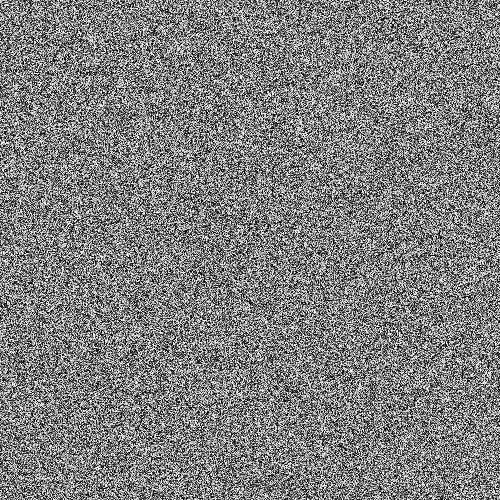

In [4]:
from keras.preprocessing import image
import numpy as np

a = np.random.random((500,500))
b = a*255.0
c = np.expand_dims(b.astype(int),axis=2)
test = image.array_to_img(c)
test